## Setup Github

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [2]:
from getpass import getpass
import os

user = "Boyne272"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

# clone the repo
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo
    
# move the repo up one
!mv repo/* .
!mv repo/.git .

# delete un needed stuff
!rm -r repo
!rm -r sample_data/

github password··········
Cloning into 'repo'...
remote: Enumerating objects: 439, done.
remote: Total 439 (delta 0), reused 0 (delta 0), pack-reused 439
Receiving objects: 100% (439/439), 64.09 MiB | 34.93 MiB/s, done.
Resolving deltas: 100% (245/245), done.
mv: cannot move 'repo/data' to './data': Directory not empty
mv: cannot move 'repo/models' to './models': Directory not empty
mv: cannot move 'repo/spec' to './spec': Directory not empty
mv: cannot move 'repo/training' to './training': Directory not empty
mv: cannot move 'repo/.git' to './.git': Directory not empty
rm: cannot remove 'sample_data/': No such file or directory


### Github Commands

In [3]:
!git checkout richard
# !git reset --hard
!git pull origin richard
!ls -l
!git log -1

D	.gitignore
Already on 'richard'
Your branch is up to date with 'origin/richard'.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Total 10 (delta 5), reused 5 (delta 5), pack-reused 5
Unpacking objects: 100% (10/10), done.
From https://github.com/msc-acse/acse-8-miniproject-softmax
 * branch            richard    -> FETCH_HEAD
   4c2dc54..ac7080b  richard    -> origin/richard
Updating 4c2dc54..ac7080b
Fast-forward
 models/Log.txt                     |   18 +-
 training/AlexNet_DropCropRot.ipynb | 1044 +++++++++++++++++++++--
 training/AlexNet_ensamble.ipynb    | 1221 +++++++++++++++++++++++++++
 training/Template_WedMorn.ipynb    | 1624 ++++++++++++++++++++++++++++++++++++
 4 files changed, 3819 insertions(+), 88 deletions(-)
 create mode 100644 training/AlexNet_ensamble.ipynb
 create mode 100644 training/Template_WedMorn.ipynb
total 40
drwxr-xr-x 2 root root  4096 May 22 05:52 data
drwx------ 3 root root  4096 May 22 05:53 gdrive
drwxr-xr-x 6

## Setup Imports

Ipython imports and functions

In [4]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


Module imports

In [0]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomCrop, ToPILImage, Pad

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# imports from github
from tools import *

Check runtime device

In [6]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


Mount google drive if wanted

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [9]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


Now set our parameters

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 30

## Data pre-processing

Define the data set creation function with the transformations.

In [0]:
def create_dataset(train, targ, t_id, v_id):
    
    # make trgets torch type and shape
    targ = torch.from_numpy(targ)
    targ = targ.long()
    # (features are changed in the transofrmations)
    
    # seperate the data
    t_feat = train[t_id]
    v_feat = train[v_id]
    t_targ = targ[t_id]
    v_targ = targ[v_id]
    
    # find mean and std
    mean, std = np.mean(t_feat)/255., np.std(t_feat)/255.
    print("avg:", mean, "std:", std)
    
    # includes data augmentation
    train_transform = Compose([
        ToPILImage(),
        RandomCrop(24),
        Pad(2),
        RandomRotation(15),
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])

    # only want to normalize here
    validation_test_transform = Compose([
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])
    
    # create the custom datasets
    train_set = CustomImageTensorDataset(t_feat, t_targ, transform=train_transform)
    valid_set = CustomImageTensorDataset(v_feat, v_targ, transform=validation_test_transform)

    return train_set, valid_set

Create the indicies for the data split

In [12]:
# do the split
n_folds = 10
shuffler =  StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
shuffler = shuffler.split(train_feat, train_targ)

# get the indices
indices = np.array(list(shuffler))
print(indices.shape)
print([i.shape for i in indices.flatten()])

(10, 2)
[(54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,)]


Divide data into n_fold sets

In [13]:
data_loders = []
for t_index, v_index in indices[:2]:
    t_set, v_set = create_dataset(train_feat, train_targ, t_index, v_index)
    data_loders.append([ DataLoader(t_set, batch_size=Batch_Size, shuffle=True),
                         DataLoader(v_set, batch_size=Test_Batch_Size, shuffle=False)])
    
data_loders = np.array(data_loders)
data_loders.shape

avg: 0.19193742228372832 std: 0.3484717402643013
avg: 0.1917338998562388 std: 0.34832169306624683


(2, 2)

Look at the data to check it is all still good

Loaded Feature Shape: torch.Size([64, 1, 28, 28])
Loaded Target Shape: torch.Size([64])
batch mean: tensor(-0.1018)
batch std: tensor(0.9344)


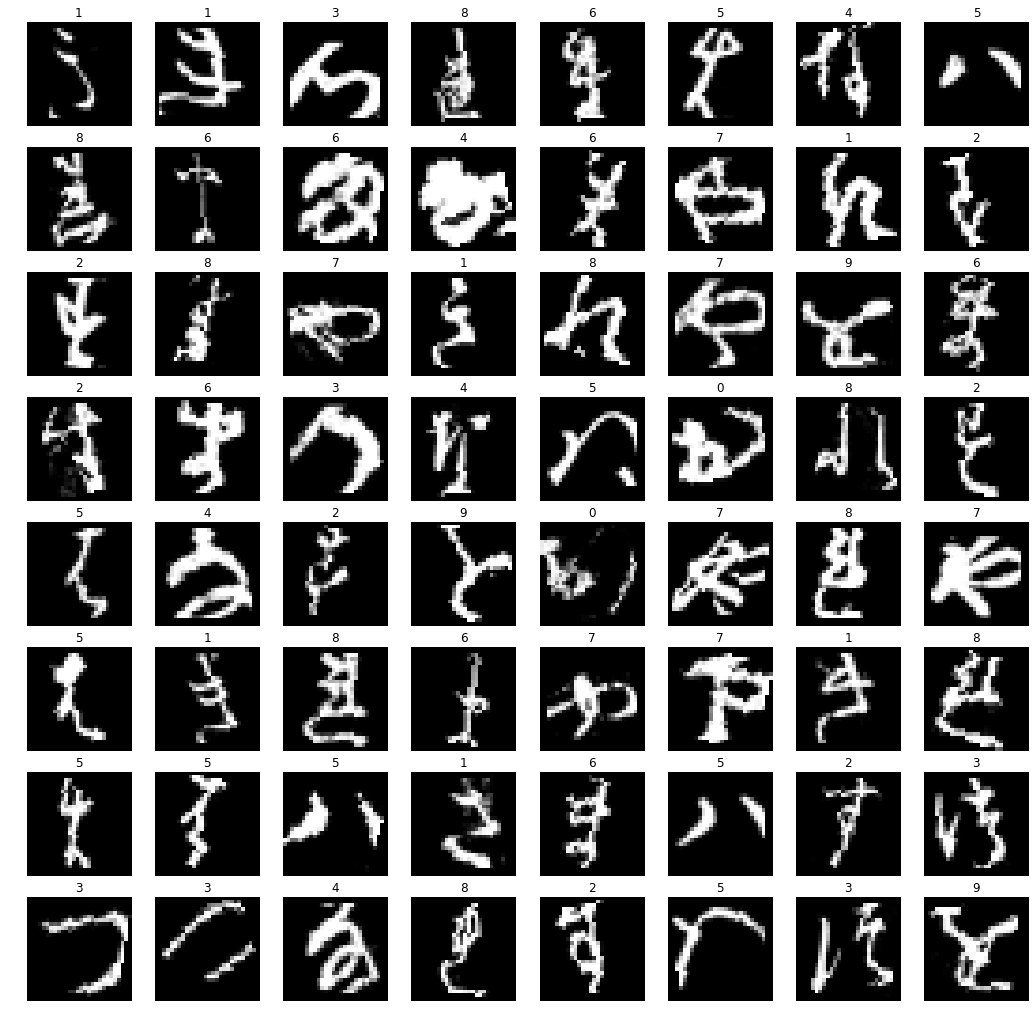

In [14]:
train_loader = data_loders[0, 0]
for X, y in train_loader:
    
    print("Loaded Feature Shape:", X.size())
    print("Loaded Target Shape:", y.size())
    print("batch mean:", X.mean())
    print("batch std:", X.std())
    
    fig, axs = plt.subplots(8, 8, figsize=[18, 18])
    
    for img, lab, ax in zip(X, y, axs.flatten()):
        ax.imshow(img[0], cmap='gray')
        ax.axis("off")
        ax.set(title=str(lab.item()))
    break

What about the standard deviation and mean. Here I manually do the transformation on each sample and look at the transformed data mean, std and shape.

In [15]:
norm = data_loders[0, 1].dataset.transform
manual = [norm(t) for t in train_feat]
manual = torch.stack(manual)
manual.mean(), manual.std(), manual.size()

(tensor(-0.0005), tensor(0.9996), torch.Size([60000, 1, 28, 28]))

## Transformation Permutaion Estimation 

In [0]:
def transform_size_est(transform, sample_image, max_iter=10000):
    
    dummy_targets = torch.ones(1).long()
    
    data_set = CustomImageTensorDataset(sample_image, dummy_targets, transform=transform)
    
    data_loader = DataLoader(data_set, shuffle=True)
    
    found_permutations = [torch.from_numpy(sample_image).float()]
    progress = []
    
    for i in range(max_iter):
        for X, y in data_loader:
            truth_arr = [torch.all(T.eq(X)) for T in found_permutations]
            if not any(truth_arr):
                found_permutations.append(X)
        
        if (i % 100) == 0:
            progress.append(len(found_permutations))
            print("iter:", i, "\t permut:", progress[-1])
            
            if i > 300 and progress[-1] == progress[-2]:
                print("No change, breaking at i:", i, "\t permutations: ", progress[-1])
                return len(found_permutations)
        
    return progress

In [57]:
trans = data_loders[0, 0].dataset.transform
progress = transform_size_est(trans, train_feat[:1])

iter: 0 	 permut: 2
iter: 100 	 permut: 98
iter: 200 	 permut: 194
iter: 300 	 permut: 275
iter: 400 	 permut: 354
iter: 500 	 permut: 439
iter: 600 	 permut: 515
iter: 700 	 permut: 600
iter: 800 	 permut: 671
iter: 900 	 permut: 749
iter: 1000 	 permut: 833
iter: 1100 	 permut: 912
iter: 1200 	 permut: 990
iter: 1300 	 permut: 1062
iter: 1400 	 permut: 1134
iter: 1500 	 permut: 1204
iter: 1600 	 permut: 1277
iter: 1700 	 permut: 1356
iter: 1800 	 permut: 1432
iter: 1900 	 permut: 1498
iter: 2000 	 permut: 1566
iter: 2100 	 permut: 1639
iter: 2200 	 permut: 1714
iter: 2300 	 permut: 1785
iter: 2400 	 permut: 1856
iter: 2500 	 permut: 1932
iter: 2600 	 permut: 2002
iter: 2700 	 permut: 2069
iter: 2800 	 permut: 2140
iter: 2900 	 permut: 2212
iter: 3000 	 permut: 2280
iter: 3100 	 permut: 2341
iter: 3200 	 permut: 2408
iter: 3300 	 permut: 2460
iter: 3400 	 permut: 2524
iter: 3500 	 permut: 2593
iter: 3600 	 permut: 2661
iter: 3700 	 permut: 2731
iter: 3800 	 permut: 2800
iter: 3900 	 p

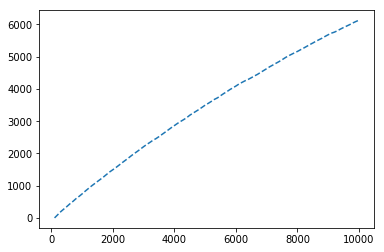

In [87]:
y = np.array(progress)
x = np.arange(1, len(progress)+1) * 100
plt.plot(x, y, "--")

In [85]:

# def to_fit(parmas):
#     print(params)
#     a, b = params
#     pred = b - np.exp(-a*x)
#     diff = y - pred
#     return ((diff)**2).sum()

# from scipy.optimize import minimize

# init = np.array([1000, 1])
# params = minimize(to_fit, init)
# plt.plot(x, y, "--")
# plt.plot(x, np.exp(params[0]*x + params[1]), "-ro")

      fun: 21581741951.561844
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1., 1.])


ValueError: ignored

In [82]:
params

      fun: 21581741951.561844
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1., 1.])